# Aptitude test for IiSGM Microbial Genomics candidates
## Rosalía Palomino Cabrera 
### 2.11.2021

In [1]:
from src.iisgm_function import read_vcf, filter_vcf, presence_matrix, d_mut, mut_dist_dnd
import os
from pyprojroot import here

### Iteration 1 | Parse VCF files to table/dataframe
Creamos la función `read_vcf` para extraer información de archivos VCF, ignorando las líneas comentadas con "##".

In [2]:
file = './data/10082989-0-COL14.combined.hf.SNP.final.vcf'
df = read_vcf(file)
df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,10082989-0-COL14
0,MTB_anc,1701,.,T,C,140323.33,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=0.814;DP=280;Ex...,GT:AD:DP:GQ:PL,"1/1:0,280:280:99:9877,832,0"
1,MTB_anc,2532,.,C,T,47660.33,PASS,AC=2;AF=1.00;AN=2;DP=81;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,81:81:99:2981,244,0"
2,MTB_anc,8040,.,G,A,88799.33,PASS,AC=2;AF=1.00;AN=2;DP=148;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,148:148:99:5057,444,0"
3,MTB_anc,9143,.,C,T,38105.33,PASS,AC=2;AF=1.00;AN=2;DP=67;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,67:67:99:2329,201,0"
4,MTB_anc,13460,.,G,A,33355.32,PASS,AC=2;AF=1.00;AN=2;DP=57;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,57:57:99:1925,171,0"
...,...,...,...,...,...,...,...,...,...,...
835,MTB_anc,4397324,.,G,C,22342.17,PASS,AC=2;AF=1.00;AN=2;DP=25;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,25:25:75:1089,75,0"
836,MTB_anc,4407588,.,C,T,45587.33,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=1.81;DP=79;Exce...,GT:AD:DP:GQ:PL,"1/1:0,79:79:99:2757,237,0"
837,MTB_anc,4408156,.,A,C,43801.33,PASS,AC=2;AF=1.00;AN=2;DP=54;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,54:54:99:2113,162,0"
838,MTB_anc,4408920,.,G,A,31138.27,PASS,AC=2;AF=1.00;AN=2;DP=60;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PGT:PID:PL:PS,"1|1:0,60:60:99:1|1:4408920_G_A:2677,181,0:4408920"


### Iteration 2 | Extract relevant information from parsed VCF

En esta etapa, eliminamos las variantes que no hayan superado los filtros de calidad, es decir, todas las filas donde la columna FILTER no aparezca como `PASS`.

Además, procedemos a eliminar las variantes que indiquen heterocigosis. Puesto que *M. tuberculosis* es haploide, no deberíamos encontrar los genotipos 0/1 o 1/2 que aparecen en algunas entradas. Estos resultados indicarían que [CombineGVCFs](https://gatk.broadinstitute.org/hc/en-us/articles/360035889691-Does-GATK-work-on-non-diploid-organisms-) no ha podido resolver la ploidía de la posición, quizás debido a un bajo coverage en la secuenciación de esas zonas. Descartamos estas variantes, ya que no se pueden extraer conclusiones fiables de las posiciones.

Como añadido y para facilitar la construcción de la matriz de ausencia/presencia, utilizamos la información del genotipo para creas dos columnas más: 

- `df['GT']`: Contiene el genotipo haploide de la muestra (1, 2, ...).
- `df['VAR']`: Contiene la variante presente en la posición. Así, podremos acceder de manera sencilla al alelo de la muestra en el caso de que la columna ALT contenga varias alternativas.

Por último, añadimos una columna final (`df['TYPE']`) donde las variantes aparecen clasificadas como SNP o INDEL, lo que nos permitirá incluir/excluir los INDELS al calcular las distancias genéticas entre las muestras.

In [3]:
f_df = filter_vcf(df)
f_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,10082989-0-COL14,GT,VAR,TYPE
0,MTB_anc,1701,.,T,C,140323.33,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=0.814;DP=280;Ex...,GT:AD:DP:GQ:PL,"1/1:0,280:280:99:9877,832,0",1,C,SNP
1,MTB_anc,2532,.,C,T,47660.33,PASS,AC=2;AF=1.00;AN=2;DP=81;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,81:81:99:2981,244,0",1,T,SNP
2,MTB_anc,8040,.,G,A,88799.33,PASS,AC=2;AF=1.00;AN=2;DP=148;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,148:148:99:5057,444,0",1,A,SNP
3,MTB_anc,9143,.,C,T,38105.33,PASS,AC=2;AF=1.00;AN=2;DP=67;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,67:67:99:2329,201,0",1,T,SNP
4,MTB_anc,13460,.,G,A,33355.32,PASS,AC=2;AF=1.00;AN=2;DP=57;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,57:57:99:1925,171,0",1,A,SNP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,MTB_anc,4397324,.,G,C,22342.17,PASS,AC=2;AF=1.00;AN=2;DP=25;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,25:25:75:1089,75,0",1,C,SNP
836,MTB_anc,4407588,.,C,T,45587.33,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=1.81;DP=79;Exce...,GT:AD:DP:GQ:PL,"1/1:0,79:79:99:2757,237,0",1,T,SNP
837,MTB_anc,4408156,.,A,C,43801.33,PASS,AC=2;AF=1.00;AN=2;DP=54;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,54:54:99:2113,162,0",1,C,SNP
838,MTB_anc,4408920,.,G,A,31138.27,PASS,AC=2;AF=1.00;AN=2;DP=60;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PGT:PID:PL:PS,"1|1:0,60:60:99:1|1:4408920_G_A:2677,181,0:4408920",1,A,SNP


### Iteration 3 | Combine present SNP into a presence matrix

Utilizando todos los archivos .vcf del directorio indicado, calculamos una matriz binaria de ausencia/presencia (1/0) donde las columnas son las mutaciones en formato POS_REF_VAR y las filas son los identificadores de las muestras.

La función `presence_matrix` permite incluir o excluir los INDELS de la matriz (parámetro `indels=False` por defecto), y por tanto del posterior cálculo de distancias.

In [4]:
direct = "/home/athena/Desktop/IiSGM-bioinfo-test/data/"
pr_mat = presence_matrix(direct, indels=True)
pr_mat.to_csv('./results/pr_ab_matrix.csv')                 # Save matrix as .csv
pr_mat

,1701_T_C,2532_C_T,8040_G_A,9143_C_T,13460_G_A,14251_G_A,14401_G_A,15117_G_C,16055_C_A,17608_G_C,...,2470723_G_A,3665501_G_A,3909875_C_T,21819_C_A,684671_C_T,2719800_T_C,257448_C_T,2941477_T_C,2074509_C_G,2468561_G_T
10105494-0-COL2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
ALM23685B3COL7,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,0
ALM93896B2COL31,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
10105494-0-COL1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
ALM93896B3COL2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
AL10105494COL0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,1,1,0,0,0,0
10082989-0-COL2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
ALM23685B3COL5,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,0
AL10082989COL3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,1,0,0
ALM93896B3COL1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


### Iterations 4, 5 and  6 | Calculate the SNP distance between all samples, Include INDELS and Represent distance in a phylogenetic tree

A partir de la matriz de ausencia/presencia, calculamos las distancias entre las muestras. 

Al estar tratando con datos binarios, utilizamos el índice de Jaccard como métrica, que nos permitirá determinar el grado de similitud entre los pares de organismos. En cuanto al algoritmo que usamos para calcular las distancias entre clusters, seleccionamos UPGMA (`method=average` en `scipy.linkage`), puesto que genera resultados buenos y consistentes, tal y como se indica en [Ojurongbe Taiwo Adetola *et al.*](https://www.elixirpublishers.com/articles/1397137198_69%20(2014)%2023111-23116.pdf) Si bien Jaccard y UPGMA son las métricas establecidas por defecto en `mut_dist`, podemos especificar parámetros diferentes con las opciones `metric` y `method`.

Para terminar, representamos los resultados con un dendrograma, que se guardará si especificamos una dirección con el parámetro `path`.

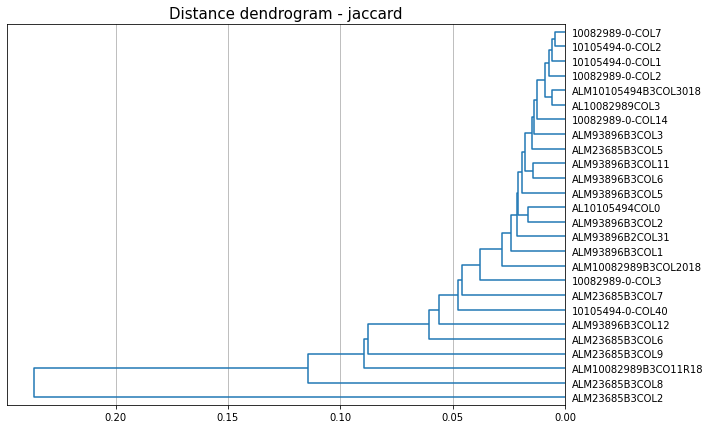

In [5]:
dist_mat_jaccard = mut_dist_dnd(pr_mat, path='./results/dendrogram.png')